In [2]:
import os
import sys
sys.path.append('/home/kal/TF_models/bin/')
os.environ['CUDA_VISIBLE_DEVICES'] = '2' # Must be before importing keras!
import tf_memory_limit

from keras import backend as K
from keras.models import load_model, Model, Input
from keras.layers import Input, Lambda, Conv1D

import numpy as np
import matplotlib.pylab as plt 
from sklearn.metrics import precision_recall_curve
from scipy.integrate import trapz
from tqdm import tqdm
import ucscgenome
import math
import pandas as pd
import time
import importlib
import pickle

import sequence
import train_TFmodel
import eval_TFmodel
import ctcfgen
import seq_only_gen
import train_seq_regression_convnet

pwm = eval_TFmodel.TFmodel('/home/kal/TF_models/seq_only/seq_classifier/pwm_frozen/')

Using TensorFlow backend.
/home/kal/TF_models/bin/sequence.py:275: RuntimeWarning: divide by zero encountered in log
  self.seq = helper.softmax(np.log(dist))


Loading model without Bias layer


In [3]:
bed_path = '/home/kal/TF_models/data/encode_chipseq_peaks.bed'
paths = dict()
ml_models = dict()
gens = dict()

In [4]:
# get already built models
for nmer_count in [1, 2, 4, 8]:
    print('Looking at nmers' + str(nmer_count))
    out_path = os.path.join('/home/kal/TF_models/seq_only/seq_regression/negative_nmers/', str(nmer_count) + '_negativeshuffled_CTCF')
    paths[nmer_count] = out_path
    gen_path = os.path.join(out_path, str(nmer_count) + '_gen.hdf5') 
    gens[nmer_count] = seq_only_gen.TFGenerator(gen_path)
    ml_models[nmer_count] = eval_TFmodel.TFmodel(out_path)

Looking at nmers1
Looking at nmers2
Looking at nmers4
Looking at nmers8


Looking at nmers1
Makeing generator for 1


727it [00:00, 7262.96it/s]

Number of training examples: 154902
Building itrtree


162209it [00:18, 8596.79it/s]


Writing hdf5 File
Finished positive training
Finished positive testing
Finished positive validation
Finished negative training
Finished negative testing
Finished negative validation
Wrote to file
Training model for 1
Convolutions used: [[32, 3], [32, 32], [16, 3], [8, 3]] [neurons, filter]
Created history pickle


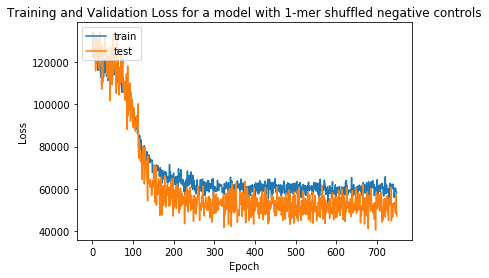

Looking at nmers2
Makeing generator for 2


757it [00:00, 7568.04it/s]

Number of training examples: 154902
Building itrtree


162209it [00:18, 8807.43it/s]


Writing hdf5 File
Finished positive training
Finished positive testing
Finished positive validation
Finished negative training
Finished negative testing
Finished negative validation
Wrote to file
Training model for 2
Convolutions used: [[32, 3], [32, 32], [16, 3], [8, 3]] [neurons, filter]
Created history pickle


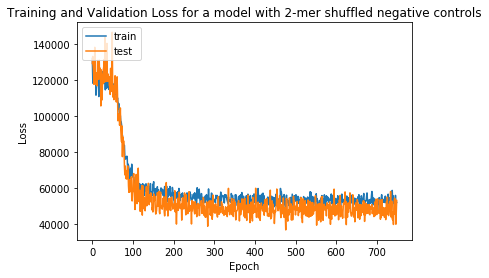

Looking at nmers4
Makeing generator for 4


466it [00:00, 4654.30it/s]

Number of training examples: 154902
Building itrtree


162209it [00:22, 7179.86it/s]


Writing hdf5 File
Finished positive training
Finished positive testing
Finished positive validation
Finished negative training
Finished negative testing
Finished negative validation
Wrote to file
Training model for 4
Convolutions used: [[32, 3], [32, 32], [16, 3], [8, 3]] [neurons, filter]
Created history pickle


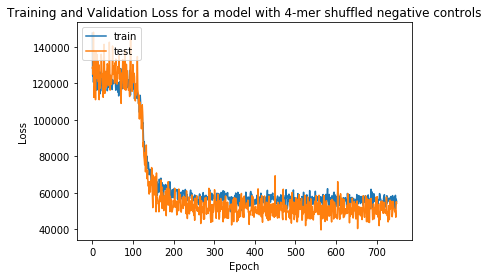

Looking at nmers8
Makeing generator for 8


740it [00:00, 7396.85it/s]

Number of training examples: 154902
Building itrtree


162209it [00:18, 8726.81it/s]


Writing hdf5 File
Finished positive training
Finished positive testing
Finished positive validation
Finished negative training
Finished negative testing
Finished negative validation
Wrote to file
Training model for 8
Convolutions used: [[32, 3], [32, 32], [16, 3], [8, 3]] [neurons, filter]
Created history pickle


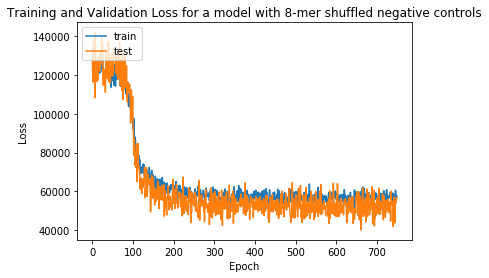

In [7]:
# make generator and model for each n mer count
for nmer_count in [1, 2, 4, 8]:
    print('Looking at nmers' + str(nmer_count))
    out_path = os.path.join('/home/kal/TF_models/seq_only/seq_regression/negative_nmers/', str(nmer_count) + '_negativeshuffled_CTCF')
    os.makedirs(out_path)
    paths[nmer_count] = out_path
    gen_path = os.path.join(out_path, str(nmer_count) + '_gen.hdf5')
    # make the generator
    print('Makeing generator for ' + str(nmer_count))
    try:
        seq_only_gen.create_from_bed(bed_path, gen_path, scrambled=nmer_count)        
        gens[nmer_count] = seq_only_gen.TFGenerator(gen_path)
        print('Training model for ' + str(nmer_count))
        # make and train the model
        train_seq_regression_convnet.make_model(out_path, '32.3_32.32_16.3_8.3', gen_path)
        ml_models[nmer_count] = eval_TFmodel.TFmodel(out_path)
        # get training loss stuff
        for file in os.listdir(os.path.join(paths[nmer_count], 'history')):
            file = os.path.join(os.path.join(paths[nmer_count], 'history'), file)
            # find the history pickles
            if file.endswith('1.pk1'):
                with open(file, 'rb') as infile:
                    h1 = pickle.load(infile)
            elif file.endswith('2.pk1'):
                with open(file, 'rb') as infile:
                    h2 = pickle.load(infile)
            elif file.endswith('3.pk1'):
                with open(file, 'rb') as infile:
                    h3 = pickle.load(infile)
        # Summarize history for accuracy
        plt.plot(eval_TFmodel.group_stats('loss', h1, h2, h3))
        plt.plot(eval_TFmodel.group_stats('val_loss', h1, h2, h3))
        plt.title('Training and Validation Loss for a model with ' + str(nmer_count) + '-mer shuffled negative controls')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
    except IndexError as e:
        print(e)

In [6]:
# predict on all atac sequences from k562 and make a p-r and p-r gain curve
npreds = dict()
bed_path = '/home/kal/TF_models/data/K562_atac_peaks/final_atac.bed'
peaks = pd.read_table(bed_path, header=None)
peaks = peaks.sample(1000)
peaks.columns = 'chr start end ctcf_label . . '.split()
peaks = peaks[peaks['chr']!='chrM']
print(len(peaks))
pwm_preds = pwm.predict_bed(peaks)
true_labels = peaks['ctcf_label']
for nmer_count in [1, 2, 4, 8]:
    npreds[nmer_count] = ml_models[nmer_count].predict_bed(peaks)


0it [00:00, ?it/s]
14it [00:00, 139.78it/s]

1000



28it [00:00, 137.34it/s]
42it [00:00, 136.55it/s]
53it [00:00, 127.17it/s]
67it [00:00, 130.42it/s]
82it [00:00, 134.13it/s]
95it [00:00, 132.33it/s]
108it [00:00, 129.57it/s]
121it [00:00, 128.15it/s]
135it [00:01, 131.44it/s]
148it [00:01, 126.01it/s]
162it [00:01, 129.40it/s]
176it [00:01, 130.72it/s]
191it [00:01, 133.16it/s]
205it [00:01, 132.62it/s]
219it [00:01, 132.25it/s]
233it [00:01, 131.66it/s]
247it [00:01, 130.37it/s]
261it [00:01, 131.86it/s]
275it [00:02, 133.23it/s]
290it [00:02, 136.27it/s]
304it [00:02, 132.56it/s]
318it [00:02, 131.32it/s]
332it [00:02, 125.91it/s]
346it [00:02, 129.08it/s]
361it [00:02, 131.22it/s]
375it [00:02, 132.41it/s]
389it [00:02, 133.45it/s]
1000it [00:07, 135.30it/s]
1000it [01:00, 16.62it/s]
1000it [00:59, 16.70it/s]
1000it [01:00, 16.66it/s]
1000it [01:00, 16.59it/s]


In [ ]:
#p-r curve
plt.figure(figsize=(8,6))
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('P-R Curve for CTCF Binding in K562 ATAC Regions')
plt.xlabel('Recall')
plt.ylabel('Precision')
pwm_p, pwm_r, pwm_t = precision_recall_curve(peaks['ctcf_label'], pwm_preds, pos_label=1)
plt.plot(pwm_r, pwm_p, label='PWM Model')
for nmer_count in [1, 2, 4, 8]:
    p, r, t = precision_recall_curve(peaks['ctcf_label'], npreds[nmer_count], pos_label=1)
    print('AOC for ' + str(nmer_count) + ': ' + str(- trapz(p,r)))
    plt.plot(r, p, label=str(nmer_count) + '-mer Model')
plt.legend()
plt.show()

/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in double_scalars
/home/thouis/VENV/lib/python3.5/site-packages/ipykernel/__main__.py:17: RuntimeWarning: divide by zero encountered in double_scalars


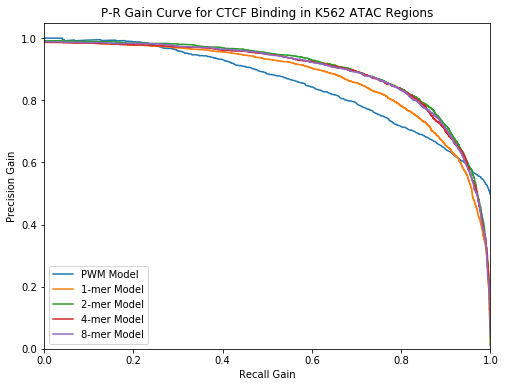

In [30]:
#p-r gain curve
plt.figure(figsize=(8,6))
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('P-R Gain Curve for CTCF Binding in K562 ATAC Regions')
plt.xlabel('Recall Gain')
plt.ylabel('Precision Gain')

prop_pos = sum(peaks['ctcf_label'])/len(peaks['ctcf_label'])
pwm_p, pwm_r, pwm_t = precision_recall_curve(peaks['ctcf_label'], pwm_preds, pos_label=1)
pwm_pgain = [(x-prop_pos)/((1-prop_pos)*x) for x in pwm_p]
pwm_rgain = [(x-prop_pos)/((1-prop_pos)*x) for x in pwm_r]
plt.plot(pwm_r, pwm_p, label='PWM Model')
for nmer_count in [1, 2, 4, 8]:
    p, r, t = precision_recall_curve(peaks['ctcf_label'], npreds[nmer_count], pos_label=1)
    pgain = [(x-prop_pos)/((1-prop_pos)*x) for x in p]
    rgain = [(x-prop_pos)/((1-prop_pos)*x) for x in r]
    plt.plot(rgain, pgain, label=str(nmer_count) + '-mer Model')
plt.legend()
plt.show()